In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, brentq
from fitting import get_phi_pd17
import fitting
from tqdm import tqdm

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
print(d[SEL]['TARGETID'][16171])
print(d[SEL]['TARGETID'].shape)
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

39627637697547336
(168482,)


In [4]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    #d1 = cosmo.comoving_distance(z1).value# Mpc
    #d2 = cosmo.comoving_distance(z2).value# Mpc
    return Planck18.comoving_volume(z2).value-Planck18.comoving_volume(z1).value

In [8]:
def get_phis(Ls, z,alpha,beta,phi_star,L_star):
    gamma1 = -alpha - 1
    gamma2 = -beta - 1
    #gamma1 -= 0.4
    #gamma2 += 0.1
    phis = phi_star / ((Ls / L_star) ** gamma1 + (Ls / L_star) ** gamma2)
    return phis

In [9]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

Processing bins: 100%|██████████| 2/2 [00:26<00:00, 13.40s/it]


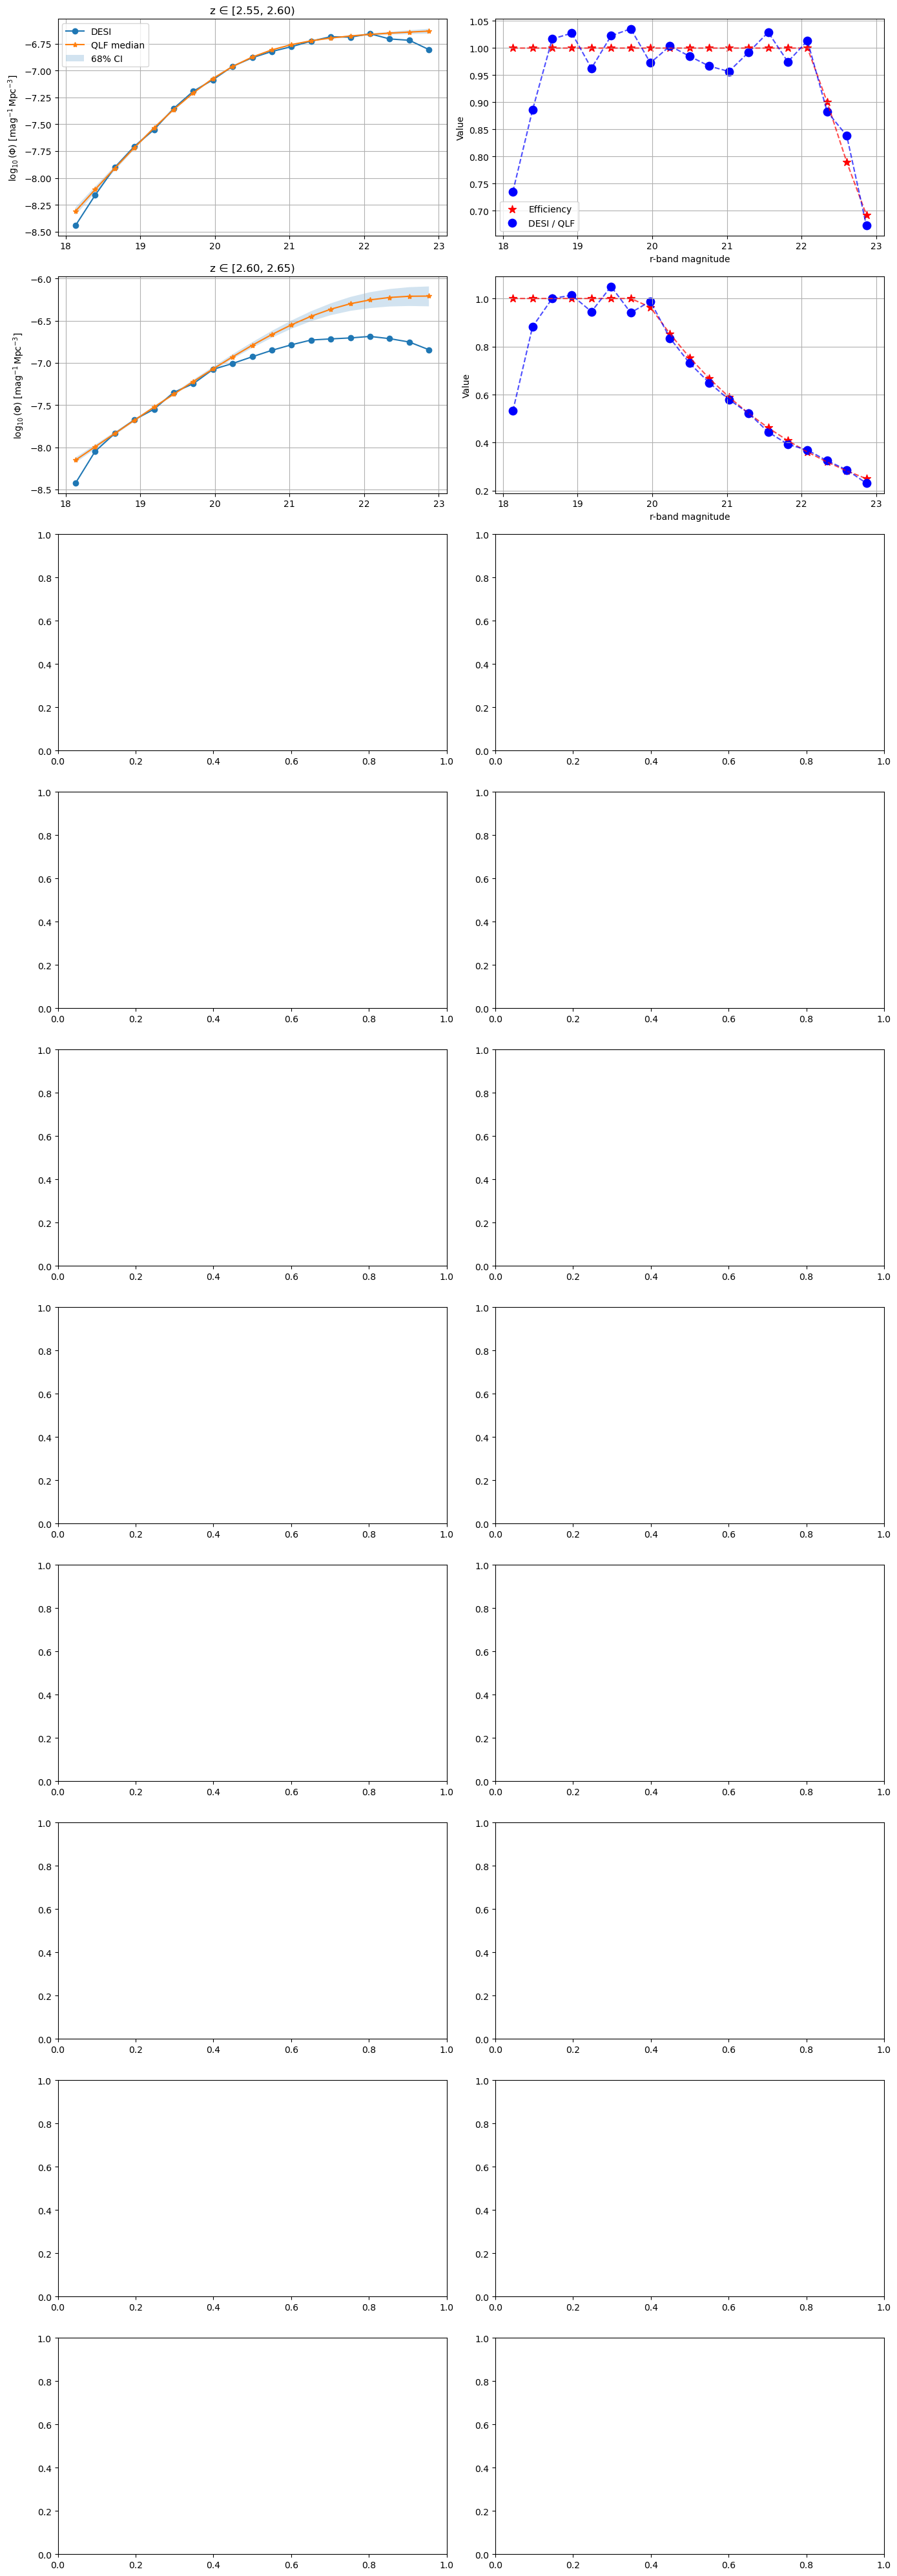

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define efficiency function
def eff(m, b, m0):
    return np.where(m < m0, 1, 10**(-b * (m - m0) / 2.5))

# File list and redshift bins
files_and_zeff = [
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples11.npz", 2.325),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples22.npz", 2.375),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples33.npz", 2.425),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples44.npz", 2.475),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples55.npz", 2.525),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples66.npz", 2.575),
    ("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples77.npz", 2.625),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples88.npz", 2.675),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples99.npz", 2.725),
    #("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples00.npz", 2.775),
]

dz = 0.05  # Bin width
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 20)
mag_r_centers = 0.5 * (mag_r_bins[:-1] + mag_r_bins[1:])
mag_r_bin_width = mag_r_bins[1] - mag_r_bins[0]

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 40))
axes = axes.reshape(10, 2)

for i, (filename, z_eff) in enumerate(tqdm(files_and_zeff, desc="Processing bins")):
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    # Load MCMC samples
    samples = np.load(filename)
    m0_median = np.median(samples['m0'])
    b_median = np.median(samples['b'])

    # Apply mask
    mask = (z_desi > zmin) & (z_desi <= zmax)
    apr_mag_r_bin = apr_mag_r[mask]
    d_bin = d_desi[mask]
    k_rr_bin = k_rr[mask]

    if len(apr_mag_r_bin) == 0:
        axes[i, 0].set_title(f"No data in z ∈ [{zmin}, {zmax})")
        axes[i, 1].axis('off')
        continue

    # DESI QLF
    counts_r, _ = np.histogram(apr_mag_r_bin, bins=mag_r_bins)
    phi_desi = counts_r / comoving_volume(zmin, zmax) / mag_r_bin_width

    # Model QLF with sampled zeta
    N = len(samples['alpha'])
    phi_qlf_chain = np.zeros((N, len(mag_r_centers)))

    for j in range(N):
        # Sample-specific absolute magnitude with zeta correction
        zeta_j = samples['zeta'][j]
        abs_mag_j = mag_r_centers - np.mean(k_rr_bin) - np.mean(d_bin) + zeta_j * (z_eff - 2.3)
        L_j = abs_mag_to_L(abs_mag_j)

        phi_qlf_chain[j] = 0.4 * get_phis(
            L_j, z_eff,
            samples['alpha'][j],
            samples['beta'][j],
            10**samples['d'][j],
            10**samples['e'][j],
        )

    # Get median and CI
    phi_qlf_med = np.median(phi_qlf_chain, axis=0)
    phi_qlf_low = np.percentile(phi_qlf_chain, 16, axis=0)
    phi_qlf_high = np.percentile(phi_qlf_chain, 84, axis=0)

    # Efficiency and ratio
    ratio = phi_desi / phi_qlf_med
    efficiency = eff(mag_r_centers, b_median, m0_median)

    # --- Upper panel: DESI vs QLF ---
    ax0 = axes[i, 0]
    ax0.plot(mag_r_centers, np.log10(phi_desi), label='DESI', marker='o')
    ax0.plot(mag_r_centers, np.log10(phi_qlf_med), label='QLF median', marker='*', linewidth=1.5)
    ax0.fill_between(mag_r_centers, np.log10(phi_qlf_low), np.log10(phi_qlf_high),
                     alpha=0.2, label='68% CI')
    ax0.set_title(f'z ∈ [{zmin:.2f}, {zmax:.2f})')
    ax0.set_ylabel(r'$\log_{10}(\Phi)\ [\mathrm{mag}^{-1}\,\mathrm{Mpc}^{-3}]$')
    ax0.grid(True)
    if i == 0:
        ax0.legend()

    # --- Lower panel: Efficiency vs Ratio ---
    ax1 = axes[i, 1]
    ax1.scatter(mag_r_centers, efficiency, color='red', marker='*', s=80, label='Efficiency')
    ax1.scatter(mag_r_centers, ratio, color='blue', marker='o', s=80, label='DESI / QLF')
    ax1.plot(mag_r_centers, efficiency, color='red', linestyle='--', alpha=0.7)
    ax1.plot(mag_r_centers, ratio, color='blue', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Value')
    ax1.set_xlabel('r-band magnitude')
    ax1.grid(True)
    if i == 0:
        ax1.legend()

plt.tight_layout()
plt.show()

Processing bins: 100%|██████████| 2/2 [00:27<00:00, 13.52s/it]


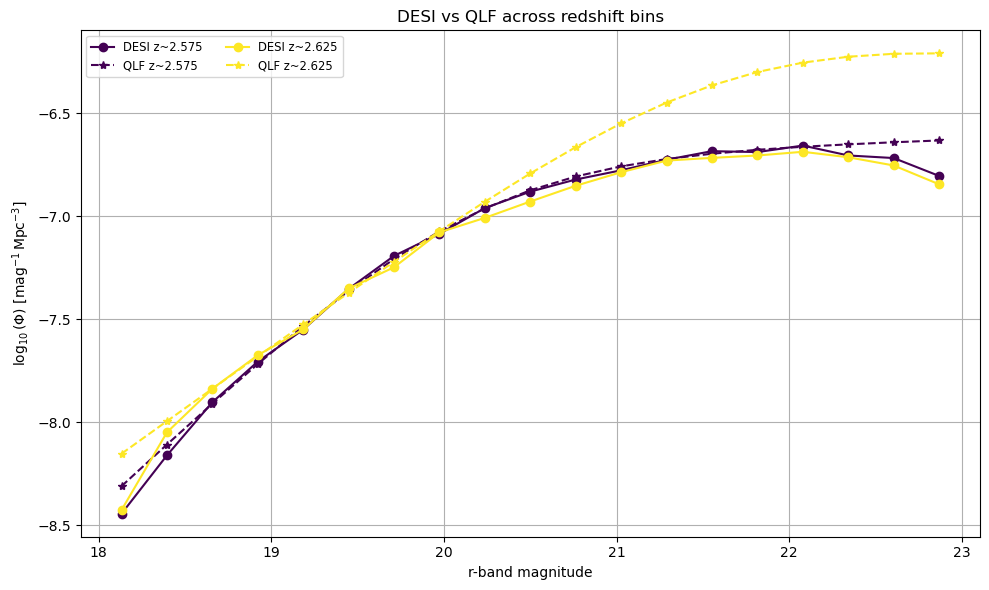

In [11]:
# --- Combined Plot for QLF and DESI across redshifts ---
fig2, ax_combined = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(files_and_zeff)))

for i, (filename, z_eff) in enumerate(tqdm(files_and_zeff, desc="Processing bins")):
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    samples = np.load(filename)
    m0_median = np.median(samples['m0'])
    b_median = np.median(samples['b'])

    mask = (z_desi > zmin) & (z_desi <= zmax)
    apr_mag_r_bin = apr_mag_r[mask]
    d_bin = d_desi[mask]
    k_rr_bin = k_rr[mask]

    if len(apr_mag_r_bin) == 0:
        continue

    counts_r, _ = np.histogram(apr_mag_r_bin, bins=mag_r_bins)
    phi_desi = counts_r / comoving_volume(zmin, zmax) / mag_r_bin_width

    N = len(samples['alpha'])
    phi_qlf_chain = np.zeros((N, len(mag_r_centers)))

    for j in range(N):
        zeta_j = samples['zeta'][j]
        abs_mag_j = mag_r_centers - np.mean(k_rr_bin) - np.mean(d_bin) + zeta_j * (z_eff - 2.3)
        L_j = abs_mag_to_L(abs_mag_j)
        phi_qlf_chain[j] = 0.4 * get_phis(
            L_j, z_eff,
            samples['alpha'][j],
            samples['beta'][j],
            10**samples['d'][j],
            10**samples['e'][j],
        )

    phi_qlf_med = np.median(phi_qlf_chain, axis=0)

    ax_combined.plot(mag_r_centers, np.log10(phi_desi), label=f'DESI z~{z_eff:.3f}', 
                     linestyle='-', marker='o', color=colors[i])
    ax_combined.plot(mag_r_centers, np.log10(phi_qlf_med), label=f'QLF z~{z_eff:.3f}', 
                     linestyle='--', marker='*', color=colors[i])

ax_combined.set_xlabel('r-band magnitude')
ax_combined.set_ylabel(r'$\log_{10}(\Phi)\ [\mathrm{mag}^{-1}\,\mathrm{Mpc}^{-3}]$')
ax_combined.set_title('DESI vs QLF across redshift bins')
ax_combined.grid(True)
ax_combined.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

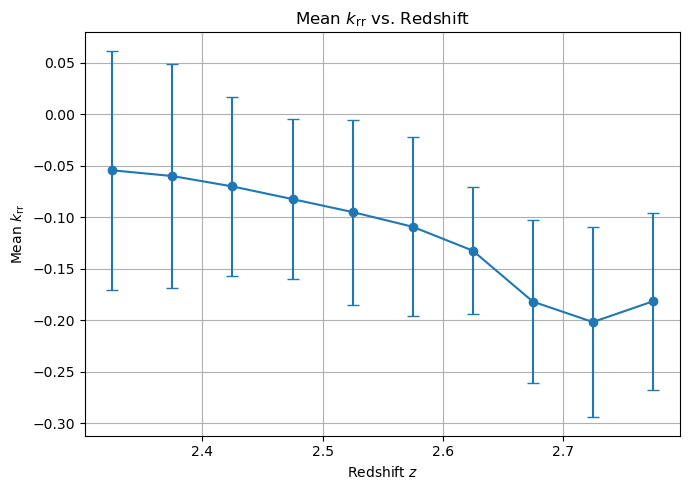

In [13]:
z_eff_list = []
k_rr_mean_list = []
k_rr_std_list = []

for _, z_eff in files_and_zeff:
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    # Apply redshift mask
    mask = (z_desi > zmin) & (z_desi <= zmax)
    k_rr_bin = k_rr[mask]

    if len(k_rr_bin) == 0:
        continue

    # Store results
    z_eff_list.append(z_eff)
    k_rr_mean_list.append(np.mean(k_rr_bin))
    k_rr_std_list.append(np.std(k_rr_bin))  # Optional: error bars

# Convert to array
z_eff_arr = np.array(z_eff_list)
k_rr_mean_arr = np.array(k_rr_mean_list)
k_rr_std_arr = np.array(k_rr_std_list)

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(z_eff_arr, k_rr_mean_arr, yerr=k_rr_std_arr, fmt='o-', capsize=4)
plt.xlabel('Redshift $z$')
plt.ylabel(r'Mean $k_\mathrm{rr}$')
plt.title(r'Mean $k_\mathrm{rr}$ vs. Redshift')
plt.grid(True)
plt.tight_layout()
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

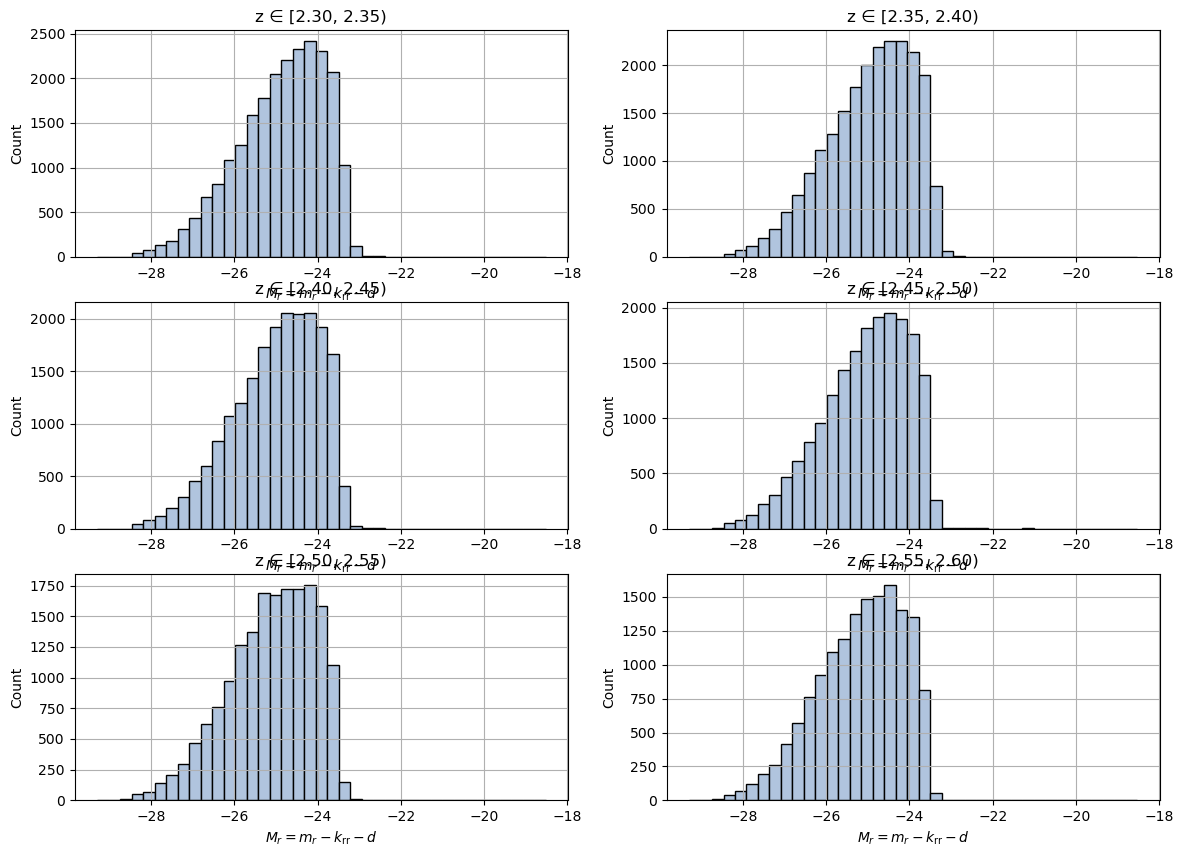

In [14]:
# Compute absolute magnitude proxy
abs_mag = apr_mag_r - k_rr - d_desi

# Global bin range for consistent histograms
abs_mag_bins = np.linspace(np.min(abs_mag), np.max(abs_mag), 40)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, (_, z_eff) in enumerate(files_and_zeff):
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    # Mask for redshift bin
    mask = (z_desi > zmin) & (z_desi <= zmax)
    abs_mag_bin = abs_mag[mask]

    # Plot histogram
    ax = axes[i]
    ax.hist(abs_mag_bin, bins=abs_mag_bins, color='lightsteelblue', edgecolor='k')
    ax.set_title(f'z ∈ [{zmin:.2f}, {zmax:.2f})')
    ax.set_xlabel(r'$M_r = m_r - k_{\rm rr} - d$')
    ax.set_ylabel('Count')
    ax.grid(True)

# Hide unused subplot (6th plot) if only 5 bins
if len(files_and_zeff) < len(axes):
    for j in range(len(files_and_zeff), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define global bin range for error histograms
err_bins = np.linspace(np.min(apr_mag_r_err), np.max(apr_mag_r_err), 30)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, (_, z_eff) in enumerate(files_and_zeff):
    zmin = z_eff - dz / 2
    zmax = z_eff + dz / 2

    # Mask for this redshift bin
    mask = (z_desi > zmin) & (z_desi <= zmax)
    mag_err_bin = apr_mag_r_err[mask]

    # Plot
    ax = axes[i]
    ax.hist(mag_err_bin, bins=err_bins, color='orchid', edgecolor='black')
    ax.set_title(f'z ∈ [{zmin:.2f}, {zmax:.2f})')
    ax.set_xlabel(r'$m_r$ error')
    ax.set_ylabel('Count')
    ax.grid(True)

# Hide unused subplot if any
if len(files_and_zeff) < len(axes):
    for j in range(len(files_and_zeff), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()